# VUS Prediction from ClinVar Germline Variants
## Patient Variant Prediction

### Purpose
Apply the trained Random Forest model to real patient VEP-annotated variants
and classify each variant as:
- Likely Pathogenic- P(Pathogenic) > 0.80
- Uncertain- 0.20 ≤ P ≤ 0.80
- Likely Benign - P(Pathogenic) < 0.20

### Critical principle
> The patient data is treated as pure inference - it never touches the model
> or thresholds. The exact same feature engineering pipeline 
> is applied using pre-saved imputation constants to ensure consistency.
> No values are recomputed from patient data.

### Inputs
- `patient_test_cleaned_noheader.tsv` -patient VEP output
- `best_model.joblib` - trained Random Forest
- `feature_cols.json` - exact feature list used in training
- `threshold_config.json` - 0.20 / 0.80 thresholds
- `imputation_constants.json` -imputation values from training set

### Outputs
- `patient_predictions.csv`- per-variant predictions with probabilities
- `patient_predictions_summary.csv`- summary counts by gene and class
- `25_patient_probability_distribution.png`
- `26_patient_gene_summary.png`

## Step 1 — Load Model, Config, and Patient Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

#Load model and config
best_model = joblib.load('best_model.joblib')
with open('best_model_name.txt') as f:
    best_model_name = f.read().strip()

with open('feature_cols.json') as f:
    feature_cols = json.load(f)

with open('threshold_config.json') as f:
    thresh_cfg = json.load(f)

with open('imputation_constants.json') as f:
    imp = json.load(f)

UPPER_THRESH     = thresh_cfg['upper_thresh']    # 0.80
LOWER_THRESH     = thresh_cfg['lower_thresh']    # 0.20
SIFT_IMPUTE      = imp['SIFT_impute']            # 0.5 (neutral)
POLYPHEN_IMPUTE  = imp['PolyPhen_impute']        # 0.0 (neutral)

print(f"Model           : {best_model_name}")
print(f"Features        : {len(feature_cols)}")
print(f"Upper threshold : {UPPER_THRESH}")
print(f"Lower threshold : {LOWER_THRESH}")
print(f"SIFT impute     : {SIFT_IMPUTE}")
print(f"PolyPhen impute : {POLYPHEN_IMPUTE}")

# Load patient data
pt = pd.read_csv('patient_test_cleaned_noheader.tsv', sep='\t', low_memory=False)
print(f"\nPatient data shape : {pt.shape}")
print(f"Unique variants    : {pt['Uploaded_variation'].nunique():,}")
print(f"Unique genes       : {pt['SYMBOL'].nunique():,}")
print(f"\nColumn check — all expected columns present:")
required = ['SIFT', 'PolyPhen', 'MAX_AF', 'IMPACT', 'VARIANT_CLASS',
            'BIOTYPE', 'MANE_SELECT', 'APPRIS', 'Consequence',
            'gnomADe_AF', 'gnomADg_AF', 'CLIN_SIG', 'Uploaded_variation']
missing = [c for c in required if c not in pt.columns]
if missing:
    print(f" Missing columns: {missing}")
else:
    print(f" All required columns present")

Model           : Random Forest
Features        : 35
Upper threshold : 0.8
Lower threshold : 0.2
SIFT impute     : 0.5
PolyPhen impute : 0.0

Patient data shape : (220, 79)
Unique variants    : 9
Unique genes       : 14

Column check — all expected columns present:
 All required columns present


## Step 2 — Check Existing Clinical Labels

In [2]:
#Check existing ClinVar labels in patient data 
print("Existing CLIN_SIG distribution in patient data:")
print(pt['CLIN_SIG'].value_counts(dropna=False).head(20).to_string())

# Flag already-classified variants
def map_clnsig_simple(value):
    val = str(value).lower().strip()
    if 'pathogenic' in val and 'conflicting' not in val: return 'Pathogenic/LP'
    elif 'benign' in val and 'conflicting' not in val:   return 'Benign/LB'
    elif 'uncertain_significance' in val:                return 'VUS'
    elif val in ['-', 'nan', '']:                        return 'Not_in_ClinVar'
    else:                                                return 'Other'

pt['clinvar_status'] = pt['CLIN_SIG'].apply(map_clnsig_simple)

print("\nSimplified ClinVar status:")
print(pt['clinvar_status'].value_counts().to_string())
print(f"\nTotal transcript rows : {len(pt):,}")
print(f"Total unique variants : {pt['Uploaded_variation'].nunique():,}")

Existing CLIN_SIG distribution in patient data:
CLIN_SIG
-                                                                                                              148
risk_factor,benign                                                                                              23
uncertain_significance                                                                                          17
not_provided,benign                                                                                             15
benign,uncertain_significance,_benign,_likely_benign,uncertain_significance,benign/likely_benign,pathogenic      9
uncertain_significance,benign,likely_benign,uncertain_significance,_benign,benign/likely_benign                  8

Simplified ClinVar status:
clinvar_status
Not_in_ClinVar    148
Benign/LB          46
VUS                17
Pathogenic/LP       9

Total transcript rows : 220
Total unique variants : 9


## Step 3 — Feature Engineering
Using pre-saved constants, not recomputed from patient data.

In [3]:
df = pt.copy()

# ── SIFT 
df['SIFT_score']   = df['SIFT'].str.extract(r'\(([\d\.]+)\)').astype(float)
df['SIFT_missing'] = df['SIFT_score'].isna().astype(int)
df['SIFT_score']   = df['SIFT_score'].fillna(SIFT_IMPUTE)
print(f"SIFT missing: {df['SIFT_missing'].sum():,} ({df['SIFT_missing'].mean()*100:.1f}%)")

# ── PolyPhen 
df['PolyPhen_score']   = df['PolyPhen'].str.extract(r'\(([\d\.]+)\)').astype(float)
df['PolyPhen_missing'] = df['PolyPhen_score'].isna().astype(int)
df['PolyPhen_score']   = df['PolyPhen_score'].fillna(POLYPHEN_IMPUTE)
print(f"PolyPhen missing: {df['PolyPhen_missing'].sum():,} ({df['PolyPhen_missing'].mean()*100:.1f}%)")

# ── Allele frequencies 
for col in ['MAX_AF', 'gnomADe_AF', 'gnomADg_AF']:
    df[col] = pd.to_numeric(
        df[col].replace('-', np.nan), errors='coerce'
    ).fillna(0)
df['MAX_AF_log'] = np.log10(df['MAX_AF'] + 1e-6)
print(f"MAX_AF nulls after imputation: {df['MAX_AF'].isna().sum()}")

# ── IMPACT ordinal encoding 
impact_map = {'HIGH': 4, 'MODERATE': 3, 'LOW': 2, 'MODIFIER': 1}
df['IMPACT_encoded'] = df['IMPACT'].map(impact_map)
# Handle any unexpected IMPACT values
n_unknown_impact = df['IMPACT_encoded'].isna().sum()
if n_unknown_impact > 0:
    print(f"⚠️  {n_unknown_impact} rows with unknown IMPACT value — filling with MODIFIER (1)")
    df['IMPACT_encoded'] = df['IMPACT_encoded'].fillna(1)

# ── MANE and APPRIS flags 
df['MANE_flag']   = df['MANE_SELECT'].apply(lambda x: 0 if str(x) == '-' else 1)
df['APPRIS_flag'] = df['APPRIS'].apply(lambda x: 0 if str(x) == '-' else 1)

SIFT missing: 150 (68.2%)
PolyPhen missing: 145 (65.9%)
MAX_AF nulls after imputation: 0


In [4]:
# BIOTYPE grouped + one-hot 
# Must produce same column names as training set
def simplify_biotype(x):
    x = str(x)
    if x in ['protein_coding', 'protein_coding_CDS_not_defined']:  return 'protein_coding'
    elif x == 'nonsense_mediated_decay':                            return 'NMD'
    elif x in ['lncRNA', 'miRNA', 'snRNA', 'snoRNA', 'misc_RNA']:  return 'non_coding_RNA'
    elif 'pseudogene' in x:                                         return 'pseudogene'
    else:                                                           return 'other'

df['BIOTYPE_grouped'] = df['BIOTYPE'].apply(simplify_biotype)
bio_dummies = pd.get_dummies(df['BIOTYPE_grouped'], prefix='BIOTYPE')
df = pd.concat([df, bio_dummies], axis=1)

# VARIANT_CLASS grouped + one-hot 
def simplify_variant_class(x):
    if x == 'SNV':                              return 'SNV'
    elif x in ['insertion','deletion','indel']: return 'INDEL'
    elif x == 'substitution':                   return 'SUBSTITUTION'
    else:                                       return 'OTHER'

df['VARIANT_CLASS_grouped'] = df['VARIANT_CLASS'].apply(simplify_variant_class)
vc_dummies = pd.get_dummies(df['VARIANT_CLASS_grouped'], prefix='VARCLASS')
df = pd.concat([df, vc_dummies], axis=1)

#  Consequence primary + one-hot 
# Use same top_csq from training — loaded via feature_cols
# Extract all CSQ categories the model was trained on from feature_cols
trained_csq_cols = [c.replace('CSQ_','') for c in feature_cols if c.startswith('CSQ_')]

df['Consequence_primary'] = df['Consequence'].str.split('&').str[0]
df['Consequence_grouped'] = df['Consequence_primary'].apply(
    lambda x: x if x in trained_csq_cols else 'other'
)
csq_dummies = pd.get_dummies(df['Consequence_grouped'], prefix='CSQ')
df = pd.concat([df, csq_dummies], axis=1)

print("Categorical encoding done")
print(f"BIOTYPE cols  : {[c for c in df.columns if c.startswith('BIOTYPE_') and c != 'BIOTYPE_grouped']}")
print(f"VARCLASS cols : {[c for c in df.columns if c.startswith('VARCLASS_') and c != 'VARCLASS_grouped']}")
print(f"CSQ cols      : {[c for c in df.columns if c.startswith('CSQ_')]}")

Categorical encoding done
BIOTYPE cols  : ['BIOTYPE_NMD', 'BIOTYPE_non_coding_RNA', 'BIOTYPE_other', 'BIOTYPE_protein_coding']
VARCLASS cols : ['VARCLASS_SNV']
CSQ cols      : ['CSQ_3_prime_UTR_variant,NMD_transcript_variant', 'CSQ_downstream_gene_variant', 'CSQ_intron_variant', 'CSQ_intron_variant,NMD_transcript_variant', 'CSQ_missense_variant', 'CSQ_missense_variant,NMD_transcript_variant', 'CSQ_non_coding_transcript_exon_variant', 'CSQ_other', 'CSQ_upstream_gene_variant']


In [6]:
for col in feature_cols:
    if col not in df.columns:
        df[col] = 0
        print(f" Column '{col}' not in patient data — filled with 0")

X_patient = df[feature_cols].copy()

# Final checks
print(f"\nPatient feature matrix shape : {X_patient.shape}")
print(f"Expected features            : {len(feature_cols)}")
print(f"Null values                  : {X_patient.isnull().sum().sum()}")
print(f"String columns               : {[c for c in feature_cols if X_patient[c].dtype == 'object']}")

assert X_patient.shape[1] == len(feature_cols), "Feature count mismatch!"
assert X_patient.isnull().sum().sum() == 0, "Nulls found in feature matrix!"
print("\n Feature matrix ready — schema matches training exactly")


Patient feature matrix shape : (220, 35)
Expected features            : 35
Null values                  : 0
String columns               : []

 Feature matrix ready — schema matches training exactly


## Step 4 — Predict & Classify Patient Variants

In [7]:
# Transcript-level predictions 
y_prob_transcript = best_model.predict_proba(X_patient)[:, 1]  # P(Pathogenic)
df['prob_pathogenic_transcript'] = y_prob_transcript

print(f"Transcript-level predictions done: {len(y_prob_transcript):,} rows")

# Aggregate to variant level: max probability across transcripts 
df_variant = df.groupby('Uploaded_variation').agg(
    prob_pathogenic_max  = ('prob_pathogenic_transcript', 'max'),
    prob_pathogenic_mean = ('prob_pathogenic_transcript', 'mean'),
    n_transcripts        = ('prob_pathogenic_transcript', 'count'),
    gene                 = ('SYMBOL', lambda x: x.mode()[0]),
    consequence          = ('Consequence_primary', lambda x: x.mode()[0]),
    impact               = ('IMPACT', lambda x: x.mode()[0]),
    variant_class        = ('VARIANT_CLASS', lambda x: x.mode()[0]),
    max_af               = ('MAX_AF', 'max'),
    clinvar_status       = ('clinvar_status', lambda x: x.mode()[0])
).reset_index()

# Apply 3-zone classification 
def classify_3zone(prob):
    if prob > UPPER_THRESH:   return 'Likely_Pathogenic'
    elif prob < LOWER_THRESH: return 'Likely_Benign'
    else:                     return 'Uncertain'

df_variant['predicted_class'] = df_variant['prob_pathogenic_max'].apply(classify_3zone)

# Summary 
n_path  = (df_variant['predicted_class'] == 'Likely_Pathogenic').sum()
n_ben   = (df_variant['predicted_class'] == 'Likely_Benign').sum()
n_unc   = (df_variant['predicted_class'] == 'Uncertain').sum()
total   = len(df_variant)

print("\n" + "=" * 60)
print(" PATIENT VARIANT PREDICTION SUMMARY")
print("=" * 60)
print(f"  Total unique variants   : {total:,}")
print(f"  Likely Pathogenic       : {n_path:,}  ({n_path/total*100:.1f}%)")
print(f"  Uncertain               : {n_unc:,}   ({n_unc/total*100:.1f}%)")
print(f"  Likely Benign           : {n_ben:,}   ({n_ben/total*100:.1f}%)")
print(f"\n  Classified (P or B)     : {(n_path+n_ben):,}  ({(n_path+n_ben)/total*100:.1f}%)")

Transcript-level predictions done: 220 rows

 PATIENT VARIANT PREDICTION SUMMARY
  Total unique variants   : 9
  Likely Pathogenic       : 0  (0.0%)
  Uncertain               : 2   (22.2%)
  Likely Benign           : 7   (77.8%)

  Classified (P or B)     : 7  (77.8%)


## Step 5 — Sanity Check Against Known ClinVar Labels

For variants that already have a ClinVar classification in the patient data,
we check whether our model agrees. This is a model validation on independent patient data- 
not used to tune anything, just to verify the model generalises correctly.

In [8]:
# Agreement check on ClinVar-annotated patient variants
known = df_variant[df_variant['clinvar_status'].isin(['Pathogenic/LP', 'Benign/LB'])].copy()

if len(known) == 0:
    print("No ClinVar-annotated variants found in patient data — skipping sanity check.")
else:
    known['model_binary'] = known['predicted_class'].map({
        'Likely_Pathogenic': 'Pathogenic/LP',
        'Likely_Benign'    : 'Benign/LB',
        'Uncertain'        : 'Uncertain'
    })

    print(f"ClinVar-annotated variants in patient data: {len(known):,}")
    print()
    print("Agreement table (ClinVar vs Model):")
    print(pd.crosstab(
        known['clinvar_status'],
        known['predicted_class'],
        margins=True
    ))

    # Concordance on confident predictions
    confident = known[known['predicted_class'] != 'Uncertain']
    if len(confident) > 0:
        agree = (
            ((confident['clinvar_status'] == 'Pathogenic/LP') &
             (confident['predicted_class'] == 'Likely_Pathogenic')) |
            ((confident['clinvar_status'] == 'Benign/LB') &
             (confident['predicted_class'] == 'Likely_Benign'))
        ).sum()
        concordance = agree / len(confident)
        print(f"\nConcordance (confident predictions only): {concordance*100:.1f}%  ({agree}/{len(confident)})")
        if concordance >= 0.90:
            print("✅ Model generalises well to patient data")
        else:
            print("Lower than expected concordance — check patient data quality")

ClinVar-annotated variants in patient data: 4

Agreement table (ClinVar vs Model):
predicted_class  Likely_Benign  All
clinvar_status                     
Benign/LB                    3    3
Pathogenic/LP                1    1
All                          4    4

Concordance (confident predictions only): 75.0%  (3/4)
Lower than expected concordance — check patient data quality


## Step 6 — Visualisations

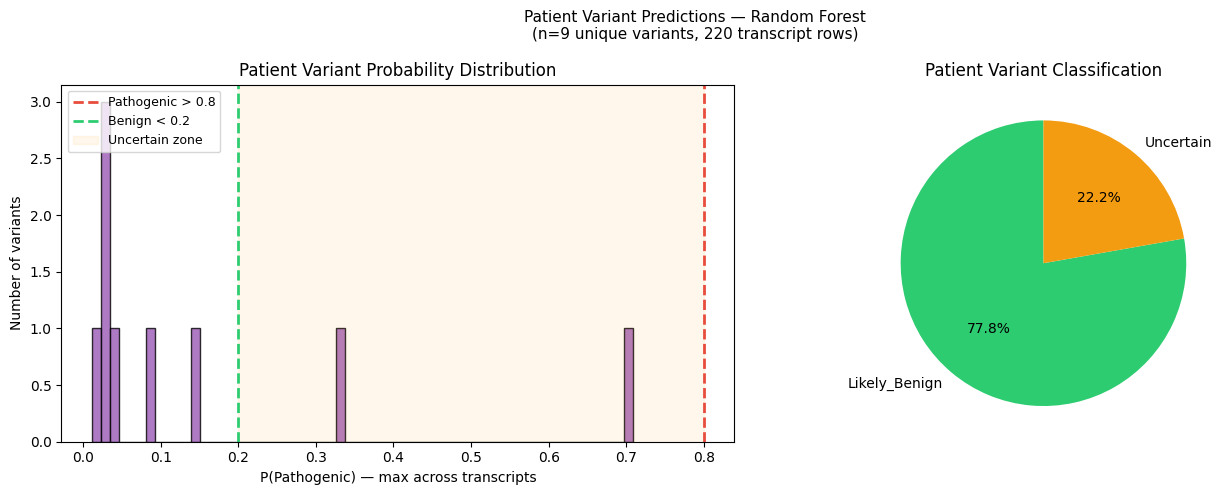

In [9]:
# ── Probability distribution
n_transcripts_total = df_variant['n_transcripts'].sum()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors_zone = {
    'Likely_Pathogenic': '#e74c3c',
    'Uncertain'        : '#f39c12',
    'Likely_Benign'    : '#2ecc71'
}
axes[0].hist(df_variant['prob_pathogenic_max'], bins=60,
             color='#9b59b6', edgecolor='black', alpha=0.8)
axes[0].axvline(UPPER_THRESH, color='#e74c3c', linestyle='--', lw=2,
                label=f'Pathogenic > {UPPER_THRESH}')
axes[0].axvline(LOWER_THRESH, color='#2ecc71', linestyle='--', lw=2,
                label=f'Benign < {LOWER_THRESH}')
axes[0].axvspan(LOWER_THRESH, UPPER_THRESH, alpha=0.08,
                color='orange', label='Uncertain zone')
axes[0].set_title('Patient Variant Probability Distribution', fontsize=12)
axes[0].set_xlabel('P(Pathogenic) — max across transcripts')
axes[0].set_ylabel('Number of variants')
axes[0].legend(fontsize=9)

zone_counts = df_variant['predicted_class'].value_counts()
axes[1].pie(
    zone_counts.values,
    labels=zone_counts.index,
    colors=[colors_zone[k] for k in zone_counts.index],
    autopct='%1.1f%%', startangle=90
)
axes[1].set_title('Patient Variant Classification', fontsize=12)

plt.suptitle(f'Patient Variant Predictions — {best_model_name}\n'
             f'(n={total:,} unique variants, {n_transcripts_total:,} transcript rows)',
             fontsize=11)
plt.tight_layout()
plt.savefig('25_patient_probability_distribution.png', dpi=150)
plt.show()

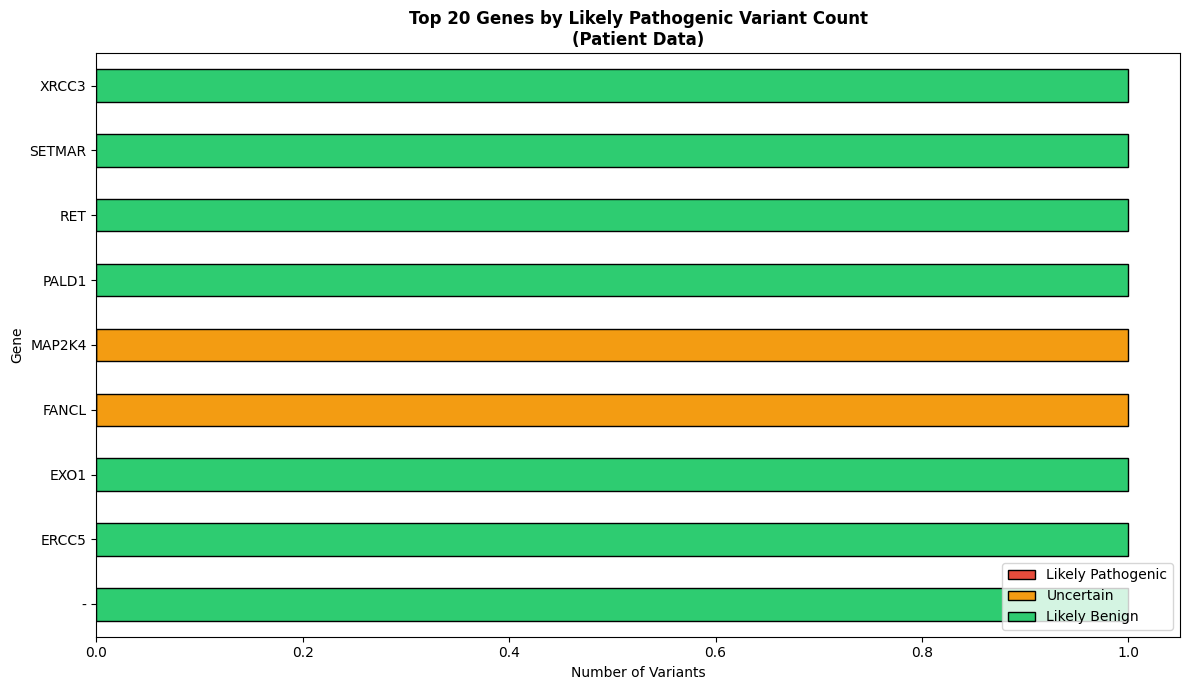


Top 20 genes (Likely Pathogenic variants):
predicted_class  Likely_Pathogenic  Uncertain  Likely_Benign  total
gene                                                               
-                                0          0              1      1
ERCC5                            0          0              1      1
EXO1                             0          0              1      1
FANCL                            0          1              0      1
MAP2K4                           0          1              0      1
PALD1                            0          0              1      1
RET                              0          0              1      1
SETMAR                           0          0              1      1
XRCC3                            0          0              1      1


In [10]:
# ── Gene-level summary: top genes with Likely Pathogenic predictions ──────────
gene_summary = df_variant.groupby(['gene', 'predicted_class']).size().unstack(fill_value=0)

# Ensure all class columns exist
for cls in ['Likely_Pathogenic', 'Uncertain', 'Likely_Benign']:
    if cls not in gene_summary.columns:
        gene_summary[cls] = 0

gene_summary['total'] = gene_summary.sum(axis=1)
gene_summary = gene_summary.sort_values('Likely_Pathogenic', ascending=False)

# Top 20 genes by Likely Pathogenic count
top_genes = gene_summary.head(20)

fig, ax = plt.subplots(figsize=(12, 7))
top_genes[['Likely_Pathogenic', 'Uncertain', 'Likely_Benign']].plot(
    kind='barh', ax=ax, stacked=True,
    color=['#e74c3c', '#f39c12', '#2ecc71'],
    edgecolor='black'
)
ax.set_title('Top 20 Genes by Likely Pathogenic Variant Count\n(Patient Data)',
             fontsize=12, fontweight='bold')
ax.set_xlabel('Number of Variants')
ax.set_ylabel('Gene')
ax.legend(['Likely Pathogenic', 'Uncertain', 'Likely Benign'], loc='lower right')
plt.tight_layout()
plt.savefig('26_patient_gene_summary.png', dpi=150)
plt.show()

print("\nTop 20 genes (Likely Pathogenic variants):")
print(top_genes[['Likely_Pathogenic','Uncertain','Likely_Benign','total']].to_string())

## Step 7 — High Priority Variants
Sorted by P(Pathogenic), highest first.

In [11]:
# High priority: Likely Pathogenic variants sorted by confidence 
high_priority = (
    df_variant[df_variant['predicted_class'] == 'Likely_Pathogenic']
    .sort_values('prob_pathogenic_max', ascending=False)
    [['Uploaded_variation', 'gene', 'consequence', 'impact',
      'variant_class', 'max_af', 'prob_pathogenic_max',
      'n_transcripts', 'clinvar_status']]
    .reset_index(drop=True)
)

print(f"High priority (Likely Pathogenic) variants: {len(high_priority):,}")
print("\nTop 20 by confidence:")
print(high_priority.head(20).round(4).to_string())

# Novel high-risk: not in ClinVar 
novel_high = high_priority[
    high_priority['clinvar_status'] == 'Not_in_ClinVar'
]
print(f"\nNovel Likely Pathogenic (not in ClinVar): {len(novel_high):,}")
if len(novel_high) > 0:
    print(novel_high.head(10).round(4).to_string())

High priority (Likely Pathogenic) variants: 0

Top 20 by confidence:
Empty DataFrame
Columns: [Uploaded_variation, gene, consequence, impact, variant_class, max_af, prob_pathogenic_max, n_transcripts, clinvar_status]
Index: []

Novel Likely Pathogenic (not in ClinVar): 0


## Step 8 — Save Results

In [12]:
# ── Full per-variant predictions 
df_variant.to_csv('patient_predictions.csv', index=False)
print(f" patient_predictions.csv  ({len(df_variant):,} variants)")

# ── Gene-level summary
gene_summary.to_csv('patient_gene_summary.csv')
print(f" patient_gene_summary.csv  ({len(gene_summary):,} genes)")

# ── High priority variants 
high_priority.to_csv('patient_high_priority.csv', index=False)
print(f" patient_high_priority.csv ({len(high_priority):,} variants)")

# ── Full transcript-level with probabilities 
df[['Uploaded_variation', 'SYMBOL', 'Consequence', 'IMPACT',
    'VARIANT_CLASS', 'MAX_AF', 'CLIN_SIG', 'clinvar_status',
    'prob_pathogenic_transcript']].to_csv(
    'patient_transcript_level_probs.csv', index=False
)
print(f" patient_transcript_level_probs.csv  ({len(df):,} transcript rows)")

print("\n" + "=" * 60)
print(" PATIENT ANALYSIS COMPLETE")
print("=" * 60)
print(f"  Model                   : {best_model_name}")
print(f"  Total unique variants   : {total:,}")
print(f"  Likely Pathogenic       : {n_path:,}  ({n_path/total*100:.1f}%)")
print(f"  Uncertain               : {n_unc:,}   ({n_unc/total*100:.1f}%)")
print(f"  Likely Benign           : {n_ben:,}   ({n_ben/total*100:.1f}%)")
print(f"  Novel high-risk variants: {len(novel_high):,}  (Likely Pathogenic, not in ClinVar)")

 patient_predictions.csv  (9 variants)
 patient_gene_summary.csv  (9 genes)
 patient_high_priority.csv (0 variants)
 patient_transcript_level_probs.csv  (220 transcript rows)

 PATIENT ANALYSIS COMPLETE
  Model                   : Random Forest
  Total unique variants   : 9
  Likely Pathogenic       : 0  (0.0%)
  Uncertain               : 2   (22.2%)
  Likely Benign           : 7   (77.8%)
  Novel high-risk variants: 0  (Likely Pathogenic, not in ClinVar)
